In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Modelo Rede Neueral Convolucional U-Net



In [2]:
import os
from sklearn.preprocessing import LabelEncoder
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
from PIL import Image
import tifffile as tiff

# NÃO RODAR

In [3]:
# NÃO USAR
#def delete_files_in_folder(folder_path):
    if not os.path.exists(folder_path):
        print(f"A pasta '{folder_path}' não existe.")
        return

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.startswith('Cópia de '):
            try:
                os.remove(file_path)
                print(f"O arquivo '{filename}' foi excluído com sucesso.")
            except OSError as e:
                print(f"Erro ao excluir o arquivo '{filename}': {e}")

# Exemplo de uso
#folder_path = '/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/slices_images'  # Substitua pelo caminho da sua pasta
#delete_files_in_folder(folder_path)

IndentationError: ignored

In [ ]:
from google.colab import drive
import shutil
import os

# Define os caminhos das pastas de origem e destino
pasta_origem = '/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/VIT_slices_masks2/'
pasta_destino = '/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/all_mask_slices/'

# Verifica se a pasta de destino existe e a cria se não existir
if not os.path.exists(pasta_destino):
    os.makedirs(pasta_destino)

# Lista os arquivos na pasta de origem
arquivos = os.listdir(pasta_origem)

# Copia os arquivos para a pasta de destino
for arquivo in arquivos:
    caminho_origem = os.path.join(pasta_origem, arquivo)
    caminho_destino = os.path.join(pasta_destino, arquivo)
    shutil.copy2(caminho_origem, caminho_destino)

print('Arquivos copiados com sucesso!')

# Import data


In [3]:
n_classes= 6 #Numero de classes
#num_images = 696  #Total 58 images data augmented to 696

Importar imagens

In [5]:
# Importar e criar dataset de imagens
file_name = glob.glob("/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Treino/VIT_slices_images/*.tif")
file_name.sort()
print(len(file_name))
images = []
for image in file_name: # para cada imagem no diretorio
    #img = Image.open(image).convert('L') # ler e converter a imagem para escala de cinza
    img = tiff.imread(image)
    # para verificar se todas imagens estao no mesmo shape. pre-processamento
    if img.shape != (256, 256):
        print(image)
        print(img.size)
    images.append(np.array(img)) # adicionar à lista
image_dataset = np.array(images) # criar array

#image_dataset = np.expand_dims(image_dataset, axis=3) # para blocos 3D ou series temporais


336


Importar masks

In [4]:
# Importar e criar dataset de masks
file_name_masks = glob.glob("/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Augmented_groundTruth/Treino/VIT_slices_masks/*.tif")
file_name_masks.sort()
print(len(file_name_masks))
masks = []
for mask in file_name_masks: # para cada imagem no diretorio
    #img = Image.open(mask)#.convert('L') # ler e converter a imagem para escala de cinza # nao precisa converter para cinza pois essa ja é escala de cinza, e estava retirando o formato tiff de algumas imagens
    img = tiff.imread(mask)
    #print(mask)
    # para verificar se todas masks estao no mesmo shape

    if img.shape != (256, 256):
        print(mask)
        print(img.size)


    img = np.array(img)
    img[img > 5] = 0 # modificar os valores dos pixels conforme a condição


    masks.append(img) # adicionar à lista de masks

mask_dataset = np.array(masks) # criar array das masks


336


Visualizar os dados
> numero de imagens e masks deve ser igual



> ambas devem ser no máximo 256x256 pixels

> len(masks) = n_classes

In [6]:
unique_mask, mask_count = np.unique(mask_dataset, return_counts=True)

print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", unique_mask)
print("Count of each label:", mask_count)


Image data shape is:  (336, 256, 256)
Mask data shape is:  (336, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5]
Count of each label: [ 444204  298674 6515172 7479820 1481436 5800790]


Codificar labels para 0, 1, 2, 3, ... matrizes multidimencionais precisam ser achatadas, codificadas e 'reshapadas'


In [7]:
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5])

In [8]:
#Normalizar o valor dos pixels das imagens, entre 0 e 1
image_dataset = image_dataset /255.

# Create Model

Dividir os dados de treino e teste

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.3, random_state = 0)

print(X_train.shape)
print(X_test.shape)

(235, 256, 256)
(101, 256, 256)


*Sanity check*, verificar alguns pares de imagens e masks


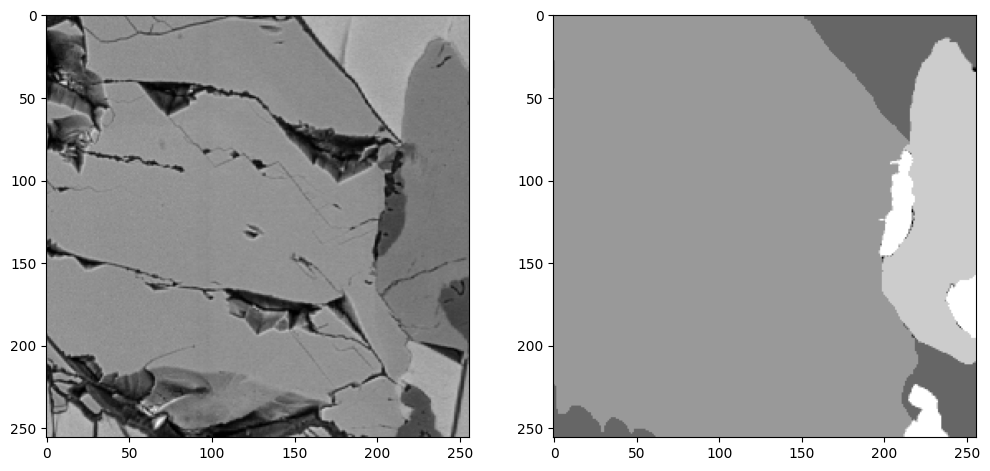

In [10]:
import random
import numpy as np

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

Transformar os dados em categóricos


In [11]:
from tensorflow.keras.utils import to_categorical
n_classes = 6
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [12]:
print(train_masks_cat.shape)
print(y_train_cat.shape)

print(np.unique(test_masks_cat))
print(test_masks_cat.shape)
print(y_test_cat.shape)

(235, 256, 256, 6)
(235, 256, 256, 6)
[0. 1.]
(101, 256, 256, 6)
(101, 256, 256, 6)


## Construir modelo Unet



*   **Conv2D()** - seta azul escuro para direita -> convoluções e criação de features (camadas)
*   **MaxPool2D()** - seta para baixo -> redução espacial da feature segundo valor máximo
*   **conv_block()** - seta para cima -> convolução para reconstruir a feature (oposto a seta para baixo)
*   **Conv2DTranspose()** - seta cinza para direita -> concatena a posição antiga dos pixels com as features convolucionadas




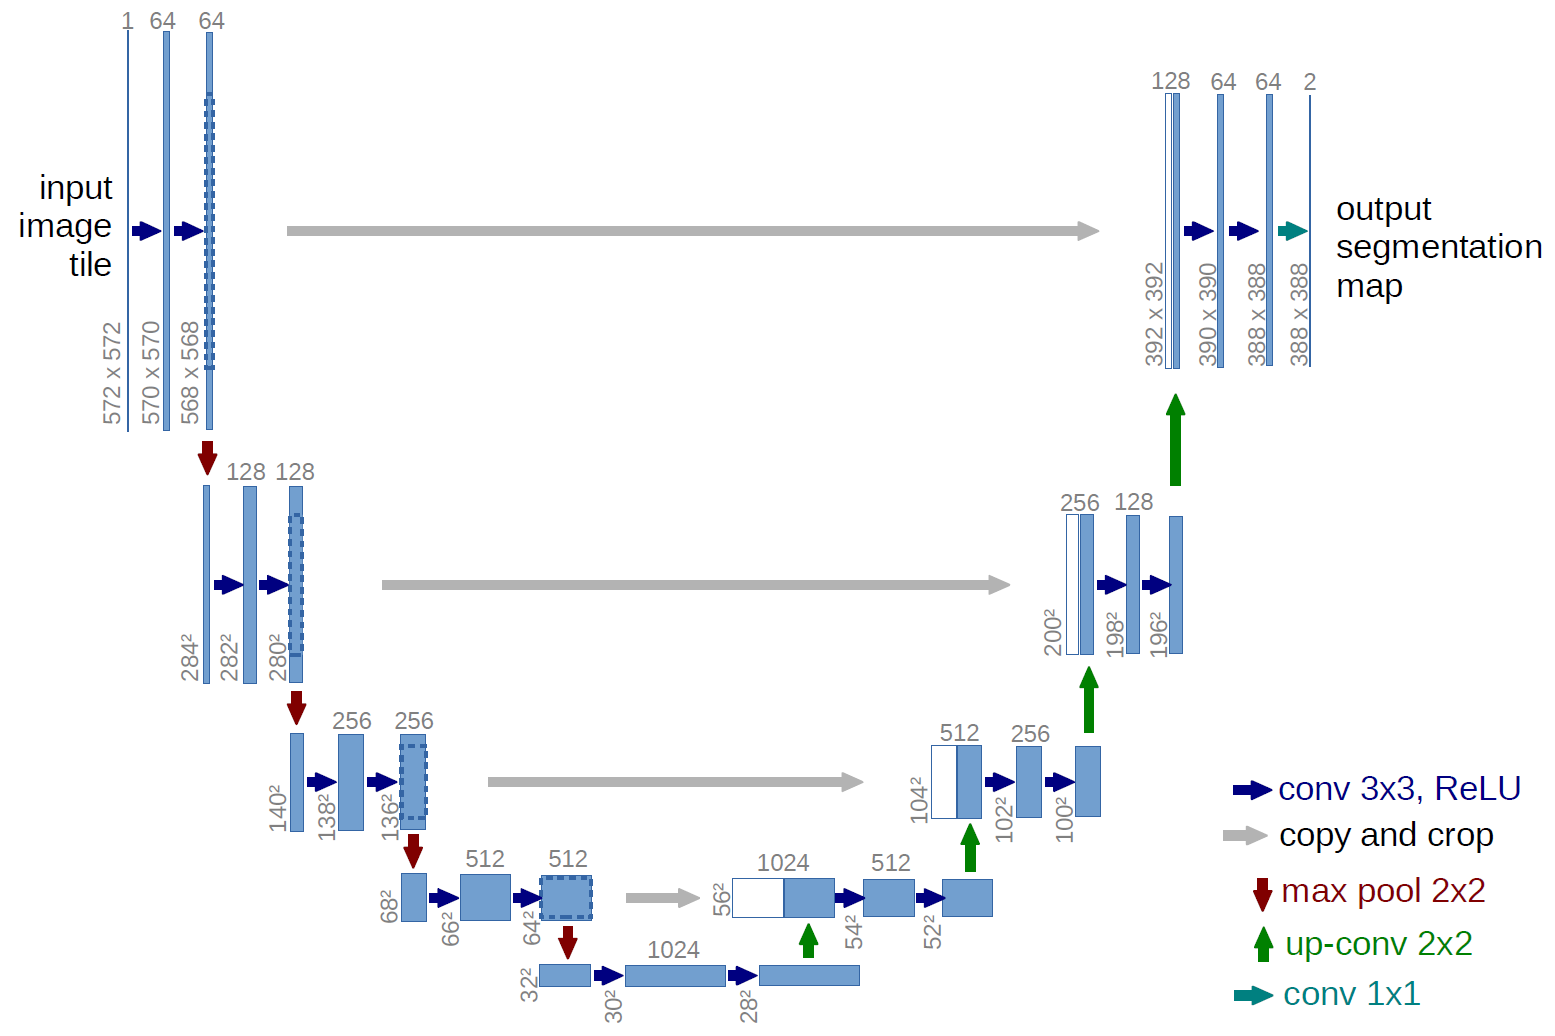

In [13]:
# Building Unet by dividing encoder and decoder into blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters): # Duas convoluções
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)   # ReLu como função de ativação

    return x


#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters) # gerar features
    p = MaxPool2D((2, 2))(x)    # Reduz as imagens a aprtir de um kernel 2x2
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])   # utiliza a posição dos pixels do encoder
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    #Change the activation based on n_classes
    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:               # mulsti-class classification
      activation = 'softmax'

    # Output convolution
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

## Modelo

Gerar pessos para as classes

>    Não Fui bem sucedido ao usar (até o momento)




In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes = np.unique(mask_dataset_reshaped_encoded),
                                                y = mask_dataset_reshaped_encoded)
print("Class weights are:", class_weights)

Transformar as classes de listas para dicionários

In [ ]:
class_weights2 = class_weights
lista = [0,1,2,3,4,5]
classWeights = dict(zip(lista, class_weights2))
print(classWeights)

In [14]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 1)


In [15]:
model = build_unet(input_shape, n_classes)
model.compile(optimizer='adam', # Adam como otimizador que utiliza backpropagation
              loss='categorical_crossentropy', # Função de custo # para classificação binária usar binary_crossentropy
              metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [16]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test_cat),
                    #class_weight=classWeights,
                    shuffle=True,
                    )

Epoch 1/100
30/30 [==============================] - 64s 900ms/step - loss: 0.6695 - accuracy: 0.7842 - val_loss: 56.1590 - val_accuracy: 0.0981
Epoch 2/100
30/30 [==============================] - 16s 546ms/step - loss: 0.3842 - accuracy: 0.8788 - val_loss: 7139.2549 - val_accuracy: 0.3580
Epoch 3/100
30/30 [==============================] - 16s 549ms/step - loss: 0.3541 - accuracy: 0.8843 - val_loss: 1450.1208 - val_accuracy: 0.3600
Epoch 4/100
30/30 [==============================] - 17s 556ms/step - loss: 0.3292 - accuracy: 0.8932 - val_loss: 52.0508 - val_accuracy: 0.3601
Epoch 5/100
30/30 [==============================] - 16s 545ms/step - loss: 0.3450 - accuracy: 0.8850 - val_loss: 4.8819 - val_accuracy: 0.3587
Epoch 6/100
30/30 [==============================] - 17s 565ms/step - loss: 0.3537 - accuracy: 0.8813 - val_loss: 5.1566 - val_accuracy: 0.2455
Epoch 7/100
30/30 [==============================] - 17s 568ms/step - loss: 0.2922 - accuracy: 0.9045 - val_loss: 7.4998 - val_a

In [ ]:
print(X_test.shape)
print(y_test_cat.shape)

(105, 256, 256)
(105, 256, 256, 6)


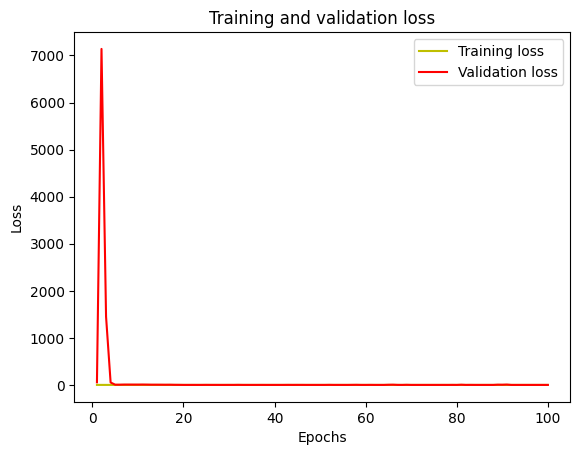

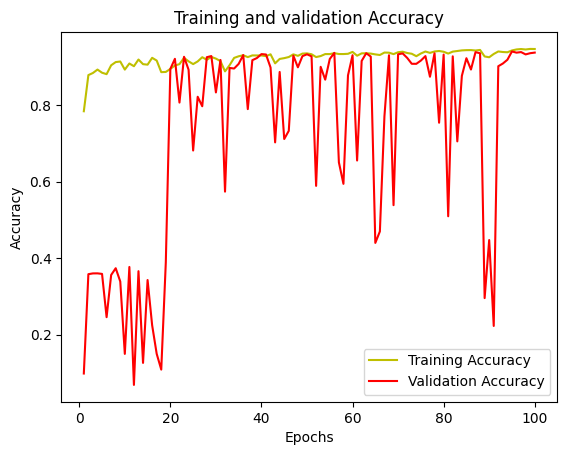

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Salvar modelos e history

In [18]:
#Save the model for future use
model.save('/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Modelos/Vit_28x12_12-07.hdf5')

# Import Model

Carregar Modelo Salvo e History

In [19]:
#Load previously saved model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/MEV - metamaficas/Projeto_Segmentação_Rocha_Máfica/Modelos/Vit_28x12_12-07.hdf5')

Predição do modelo com os dados de teste

In [20]:
y_pred=model.predict(X_test)
y_pred.shape

4/4 [==============================] - 20s 377ms/step


(101, 256, 256, 6)

In [21]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(101, 256, 256)

# Métricas

In [22]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = n_classes
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7298742


IoU de cada mineral

In [23]:
#To calculate I0U for 6 classes
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
#print(values)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4]+ values[0,5]+ values[1,0]+ values[2,0]+ values[3,0]+ values[4,0]+ values[5,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4]+ values[1,5]+ values[0,1]+ values[2,1]+ values[3,1]+ values[4,1]+ values[5,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4]+ values[2,5]+ values[0,2]+ values[1,2]+ values[3,2]+ values[4,2]+ values[5,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4]+ values[3,5]+ values[0,3]+ values[1,3]+ values[2,3]+ values[4,3]+ values[5,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[4,5]+ values[0,4]+ values[1,4]+ values[2,4]+ values[3,4]+ values[5,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3]+ values[5,4]+ values[0,5]+ values[1,5]+ values[2,5]+ values[3,5]+ values[4,5])

print("IoU para o fundo is: ", class1_IoU)
print("IoU para titanita is: ", class2_IoU)
print("IoU para biotita is: ", class3_IoU)
print("IoU para anfibólio is: ", class4_IoU)
print("IoU para k-feldspato is: ", class5_IoU)
print("IoU para plagioclásio is: ", class6_IoU)

IoU para o fundo is:  0.22507644
IoU para titanita is:  0.6316353
IoU para biotita is:  0.9044278
IoU para anfibólio is:  0.90898556
IoU para k-feldspato is:  0.79197043
IoU para plagioclásio is:  0.91714984


Testar algumas predições

1/1 [==============================] - 0s 21ms/step


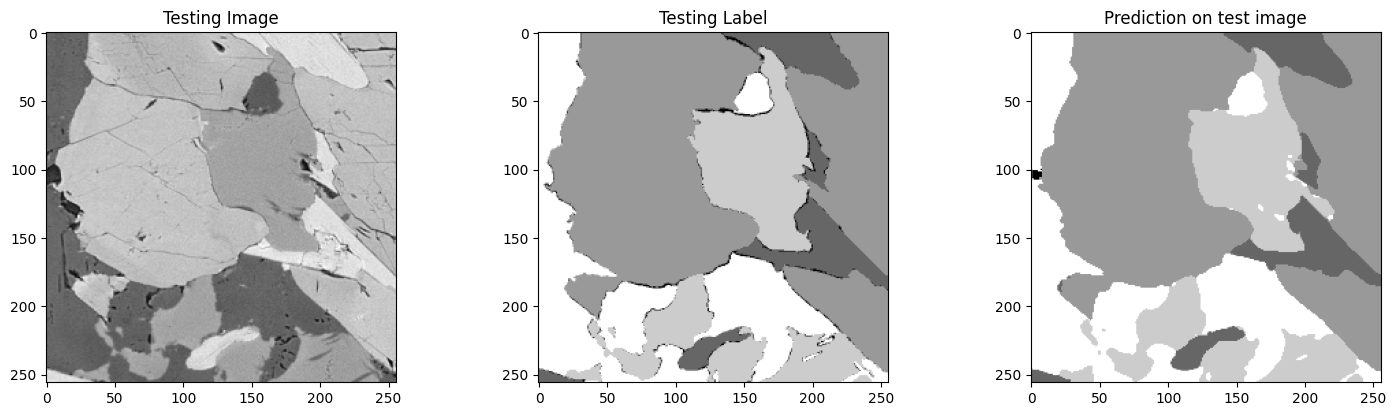

In [26]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

Confusion Matrix

In [27]:
y_test_lin = y_test.ravel()
y_pred_lin = y_pred_argmax.ravel()

print(y_test_lin.shape)
print(y_pred_lin.shape)
print(np.unique(y_test_lin))
print(np.unique(y_pred_lin))

(6619136,)
(6619136,)
[0 1 2 3 4 5]
[0 1 2 3 4 5]


<Axes: >

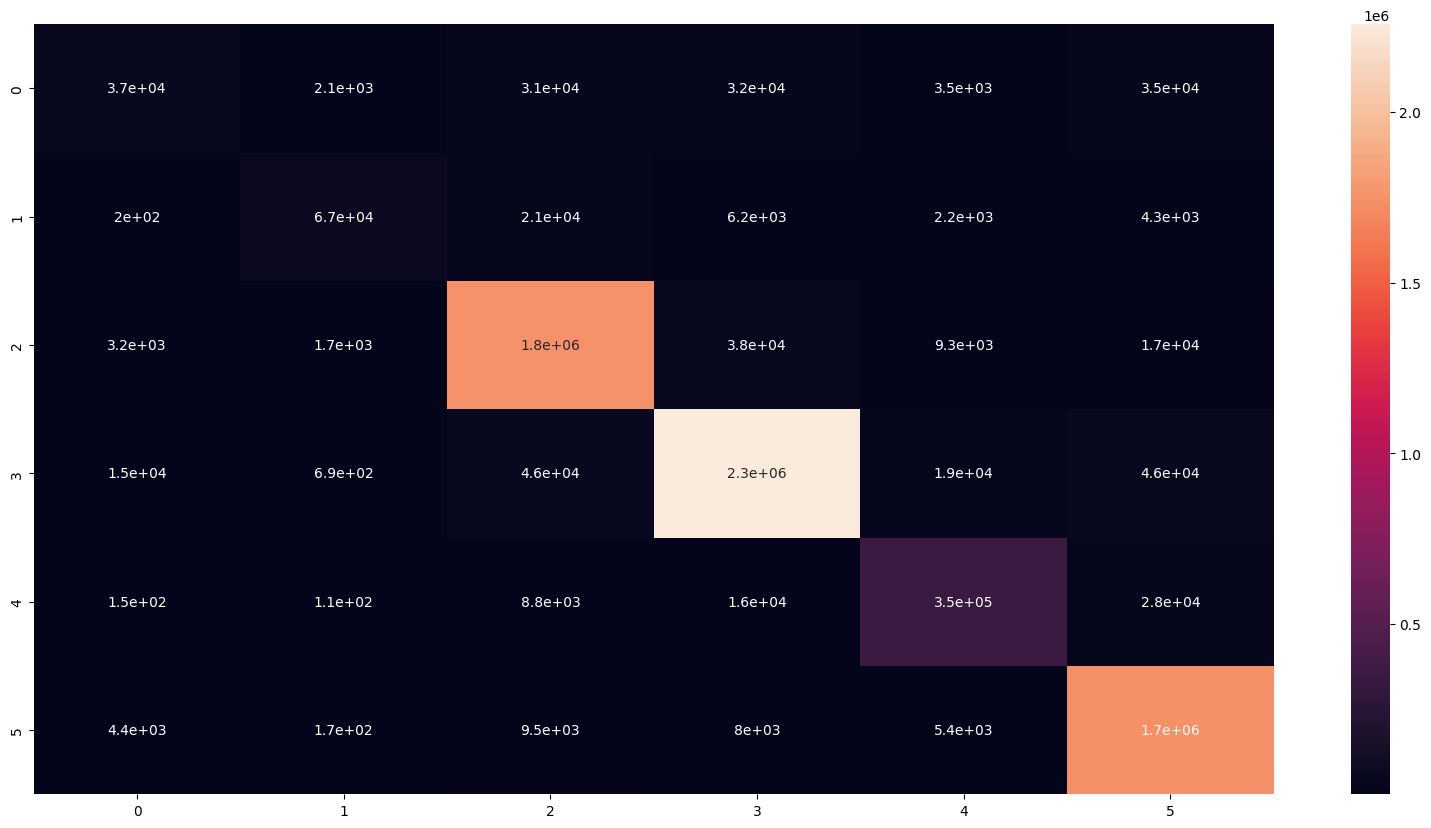

In [28]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = np.unique(y_pred_lin)
cm = confusion_matrix(y_test_lin, y_pred_lin, labels=labels)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True)

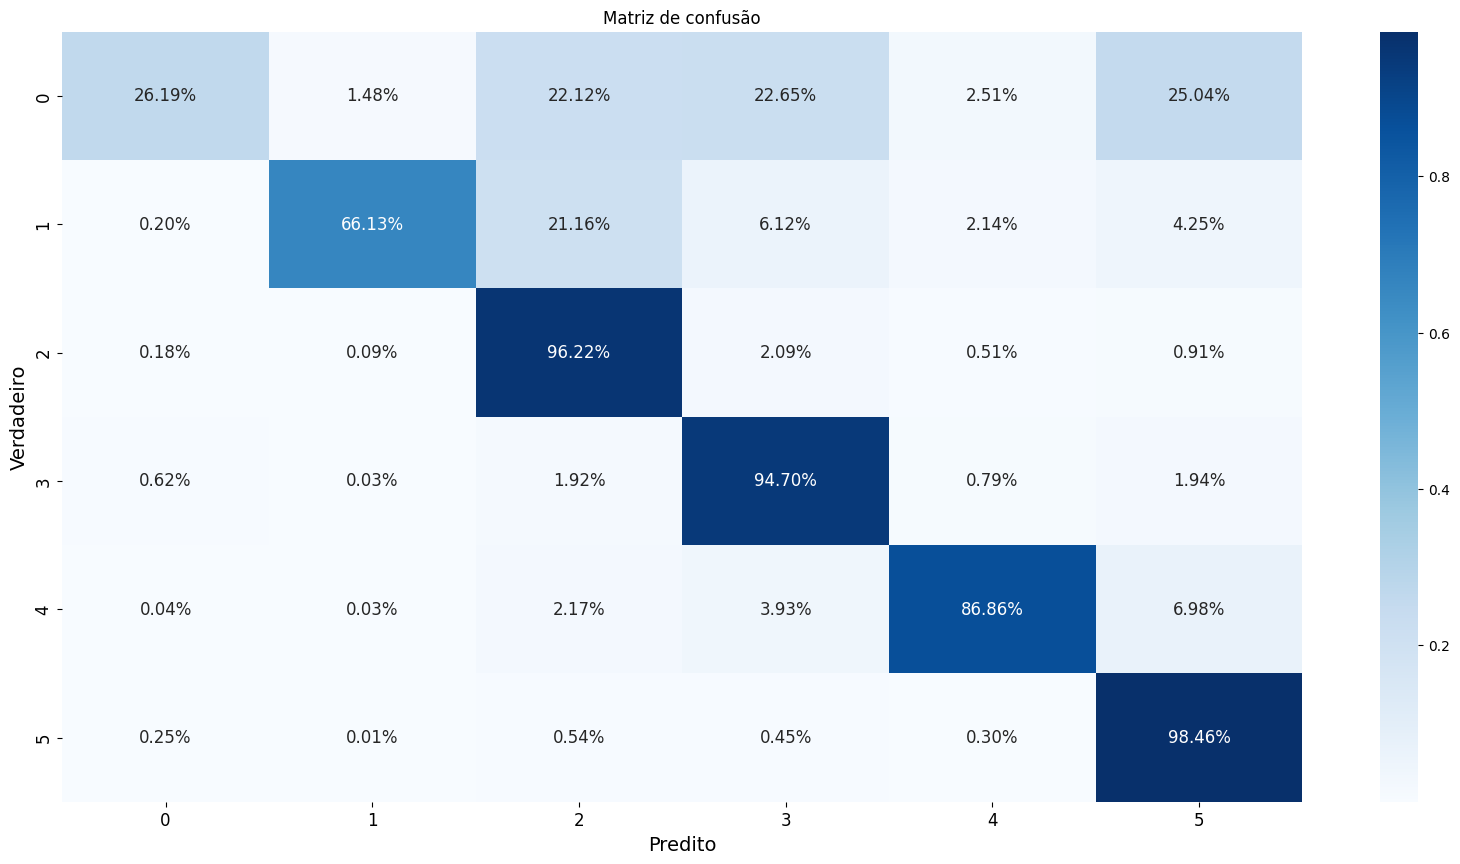

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = np.unique(y_pred_lin)
cm = confusion_matrix(y_test_lin, y_pred_lin, labels=labels)

# Converter a matriz de contagem em porcentagem
cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 10))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues", annot_kws={"fontsize": 12})

plt.xticks(fontsize=12)  # Aumentar o tamanho da fonte para os valores do eixo x
plt.yticks(fontsize=12)  # Aumentar o tamanho da fonte para os valores do eixo y


plt.xlabel('Predito', fontsize=14)
plt.ylabel('Verdadeiro', fontsize=14)

plt.title('Matriz de confusão')

plt.show()


In [30]:
print(y_pred[:,:,:,0].shape)
print(y_test_cat[:,:,:,0].shape)

(76, 256, 256)
(76, 256, 256)


ROC curves

In [31]:
#ROC
from sklearn.metrics import roc_curve

y_test_lin0 = y_test_cat[:,:,:,0].ravel()
y_pred_lin0 = y_pred[:,:,:,0].ravel()
fpr0, tpr0, thresholds0 = roc_curve(y_test_lin0, y_pred_lin0)

y_test_lin1 = y_test_cat[:,:,:,1].ravel()
y_pred_lin1 = y_pred[:,:,:,1].ravel()
fpr1, tpr1, thresholds1 = roc_curve(y_test_lin1, y_pred_lin1)

y_test_lin2 = y_test_cat[:,:,:,2].ravel()
y_pred_lin2 = y_pred[:,:,:,2].ravel()
fpr2, tpr2, thresholds2 = roc_curve(y_test_lin2, y_pred_lin2)

y_test_lin3 = y_test_cat[:,:,:,3].ravel()
y_pred_lin3 = y_pred[:,:,:,3].ravel()
fpr3, tpr3, thresholds3 = roc_curve(y_test_lin3, y_pred_lin3)

y_test_lin4 = y_test_cat[:,:,:,4].ravel()
y_pred_lin4 = y_pred[:,:,:,4].ravel()
fpr4, tpr4, thresholds4 = roc_curve(y_test_lin4, y_pred_lin4)

y_test_lin5 = y_test_cat[:,:,:,5].ravel()
y_pred_lin5 = y_pred[:,:,:,5].ravel()
fpr5, tpr5, thresholds5 = roc_curve(y_test_lin5, y_pred_lin5)


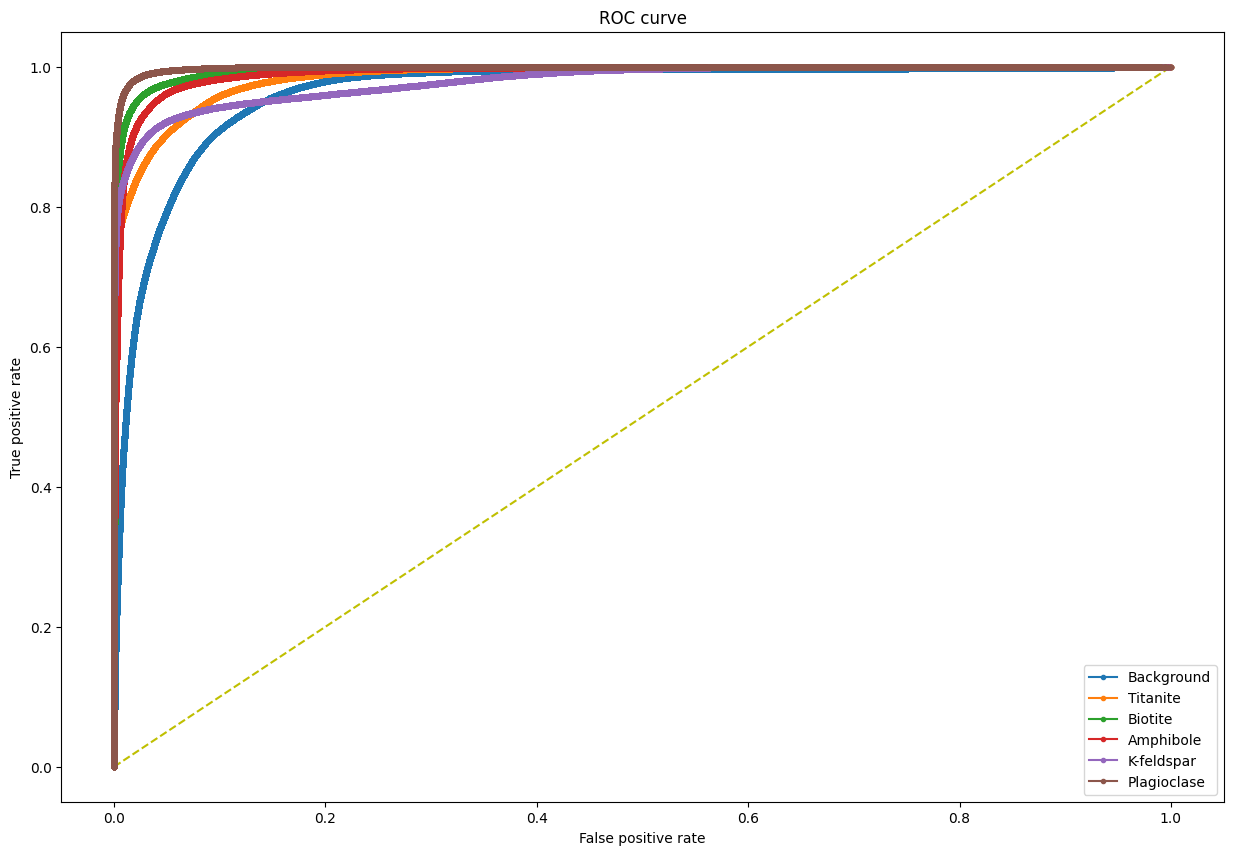

In [32]:
#Plotting

plt.figure(1, figsize=(15,10))
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr0, tpr0, marker='.', label='Background')
plt.plot(fpr1, tpr1, marker='.', label='Titanite')
plt.plot(fpr2, tpr2, marker='.', label='Biotite')
plt.plot(fpr3, tpr3, marker='.', label='Amphibole')
plt.plot(fpr4, tpr4, marker='.', label='K-feldspar')
plt.plot(fpr5, tpr5, marker='.', label='Plagioclase')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

AUC

In [33]:
from sklearn.metrics import roc_auc_score

auc0 = roc_auc_score(y_test_lin0, y_pred_lin0)
auc1 = roc_auc_score(y_test_lin1, y_pred_lin1)
auc2 = roc_auc_score(y_test_lin2, y_pred_lin2)
auc3 = roc_auc_score(y_test_lin3, y_pred_lin3)
auc4 = roc_auc_score(y_test_lin4, y_pred_lin4)
auc5 = roc_auc_score(y_test_lin5, y_pred_lin5)

print("AUC-ROC for Class 0:", auc0)
print("AUC-ROC for Class 1:", auc1)
print("AUC-ROC for Class 2:", auc2)
print("AUC-ROC for Class 3:", auc3)
print("AUC-ROC for Class 4:", auc4)
print("AUC-ROC for Class 5:", auc5)

AUC-ROC for Class 0: 0.9655373307603478
AUC-ROC for Class 1: 0.9854680900345391
AUC-ROC for Class 2: 0.9951799701574613
AUC-ROC for Class 3: 0.991187967065556
AUC-ROC for Class 4: 0.9798155073303082
AUC-ROC for Class 5: 0.9984244517795262


Métricas do ChatGPT

In [34]:
import numpy as np
from keras.metrics import MeanIoU
from keras.metrics import Precision, Recall
from keras.metrics import Accuracy
from keras.metrics import binary_accuracy
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical

# Função para calcular a métrica Intersection over Union (IoU)
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Função para calcular o coeficiente DICE
def calculate_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2.0 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

In [35]:
# Converte as máscaras para one-hot encoding
y_true = to_categorical(y_test_cat, num_classes=6)
y_pred = to_categorical(y_pred, num_classes=6)

# Número de classes
num_classes = y_true.shape[2]


In [36]:
# Calcula as métricas para o modelo
iou = calculate_iou(y_true, y_pred)
dice = calculate_dice(y_true, y_pred)

In [37]:
# Métricas do Keras
mean_iou = MeanIoU(num_classes=num_classes)
mean_iou.update_state(y_true, y_pred)
precision = Precision()
precision.update_state(y_true, y_pred)
recall = Recall()
recall.update_state(y_true, y_pred)
accuracy = Accuracy()
accuracy.update_state(y_true, y_pred)
binary_acc = binary_accuracy(y_true, y_pred)
categorical_acc = categorical_accuracy(y_true, y_pred)

In [38]:
# Exibe as métricas calculadas para o modelo
print("Model Metrics:")
print("IoU:", iou)
print("DICE Coefficient:", dice)
print("Mean IoU (Keras):", mean_iou.result().numpy())
print("Precision (Keras):", precision.result().numpy())
print("Recall (Keras):", recall.result().numpy())
print("Accuracy (Keras):", accuracy.result().numpy())
#print("Binary Accuracy (Keras):", binary_acc.numpy())
#print("Categorical Accuracy (Keras):", categorical_acc.numpy())

Model Metrics:
IoU: 0.7142857634547459
DICE Coefficient: 0.83333336679559
Mean IoU (Keras): 0.627451
Precision (Keras): 0.8333333
Recall (Keras): 0.8333333
Accuracy (Keras): 0.9444444


In [ ]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection + 1e-7) / (union + 1e-7)

n_classes = 6

# Calculate Dice coefficient for all classes
dice_general = dice_coefficient(y_test.flatten(), y_pred.flatten())

print("Dice coefficient (general) =", dice_general)

# Calculate Dice coefficient for each class
dice_classes = []
for i in range(n_classes):
    dice_class = dice_coefficient(y_test[:,:,:,i].flatten(), y_pred[:,:,:,i].flatten())
    dice_classes.append(dice_class)
    print("Dice coefficient for class", i+1, "=", dice_class)

Dice coefficient (general) = 0.6364503936740141


IndexError: ignored